<h2><strong>ANALIZA FORBESOVE LESTVICE MILJARDERJEV</strong></h2>

In [1]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10

%matplotlib notebook
%matplotlib inline

In [2]:
# forbes:
forbes = pd.read_csv(os.path.join('Obdelani-podatki/forbes.csv'))
forbes['name'] = forbes.name.str.replace('&amp;', '&')
forbes['industry'] = forbes.industry.str.replace('&amp;', '&')
forbes['age'] = forbes['age'].astype('Int64')

# worldpopulation:
drzave = pd.read_csv(os.path.join('Obdelani-podatki/worldpopulation.csv'))
forbes

,name,networth,age,country,source,industry
0,Elon Musk,$219 B,50,United States,"Tesla, SpaceX",Automotive
1,Jeff Bezos,$171 B,58,United States,Amazon,Technology
2,Bernard Arnault & family,$158 B,73,France,LVMH,Fashion & Retail
3,Bill Gates,$129 B,66,United States,Microsoft,Technology
4,Warren Buffett,$118 B,91,United States,Berkshire Hathaway,Finance & Investments
...,...,...,...,...,...,...
2595,Jorge Gallardo Ballart,$1 B,80,Spain,pharmaceuticals,Healthcare
2596,Nari Genomal,$1 B,82,Cyprus,apparel,Fashion & Retail
2597,Ramesh Genomal,$1 B,71,Cyprus,apparel,Fashion & Retail
2598,Sunder Genomal,$1 B,68,United Kingdom,garments,Fashion & Retail


<h4>STAROSTNA STRUKTURA</h4>

Text(67.49087837837838, 292.005, 'Povprečna starost: 64')

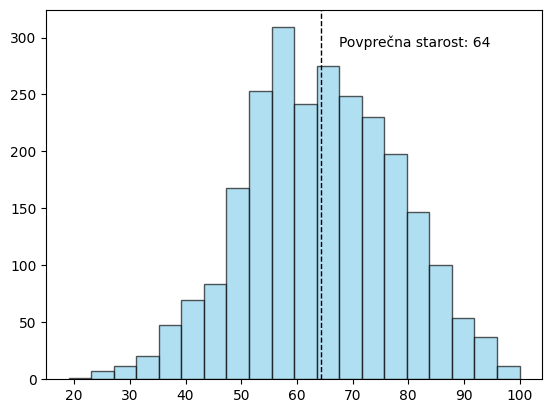

In [54]:
forbes_age = forbes.age.dropna()
result = plt.hist(forbes_age, bins=20, color='skyblue', edgecolor='k', alpha=0.65)
plt.axvline(forbes_age.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(forbes_age.mean()*1.05, max_ylim * 0.9, 'Povprečna starost: {:.0f}'.format(forbes_age.mean()))